In [ ]:
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
import torch

In [2]:
# Check if GPU is available
torch.cuda.is_available()

True

In [3]:
# Load and preprocess data
training = pd.read_csv('training.csv')
testing = pd.read_csv('test.csv')

y_train = training.iloc[:, :30]

# Get the last feature column
lastFeature = training.iloc[:, -1]

# Split the last feature by spaces
splitFeatures = lastFeature.str.split(' ', expand=True)

# Drop the original last feature and concatenate the new split features
training = pd.concat([training.drop(training.columns[-1], axis=1), splitFeatures], axis=1)
testing = pd.concat([testing.drop(testing.columns[-1], axis=1), splitFeatures], axis=1)

# Drop the first columns here so they aren't mislabeled, and this way we can just make this the X_train
training.drop(training.columns[range(0, 30)], axis=1, inplace=True)

# Rename the columns to pixel_i
training.columns = [f'pixel_{i}' for i in range(training.shape[1])]
testing.columns = [f'pixel_{i}' for i in range(testing.shape[1])]

# There was an extra column that was just the index
testing.drop(columns=testing.columns[[0]], inplace=True)

# Rename the columns to pixel_i
testing.columns = ['ImageId'] + [f'pixel_{i}' for i in range(1, testing.shape[1])]

X_train = training
X_test = testing

# Reshape dataframe into numpy array so I can reshape it again
X_train = X_train.to_numpy(dtype=np.float32)

# Reshape image data so the model can process it as a Tensor
X_train = X_train.reshape(-1, 1, 96, 96)
X_train = X_train / 255.0

# Reshape y_train into a numpy array as well
y_train_copy = y_train.copy()
y_train_copy = y_train_copy.notna().astype(np.float32)
y_train_copy = y_train_copy.to_numpy(dtype=np.int32)

# Fill in missing values with the previous row
y_train.fillna(method="ffill", inplace=True)
# Fill in missing values with the next row
y_train.fillna(method="bfill", inplace=True)
y_train = np.array(y_train, dtype=np.float32)

# Reshape test data
X_test = X_test.to_numpy(dtype=np.float32)
X_test = X_test.reshape(-1, 1, 96, 96)
X_test = X_test / 255.0


C:\Users\jespy\AppData\Local\Temp\ipykernel_11016\3011135401.py:46: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  y_train.fillna(method="ffill", inplace=True)
C:\Users\jespy\AppData\Local\Temp\ipykernel_11016\3011135401.py:48: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  y_train.fillna(method="bfill", inplace=True)


In [4]:
class ImprovedCnnModel(nn.Module):
    def __init__(self):
        super(ImprovedCnnModel, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(256 * 6 * 6, 512)  # Adjusted for 96x96 input
        self.bn2 = nn.BatchNorm1d(512)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(512, 30)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        x = x.view(-1, 256 * 6 * 6)
        x = F.relu(self.bn2(self.fc1(x)))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# Convert data to PyTorch tensors and create DataLoader
xTrainTensor = torch.tensor(X_train.reshape(-1, 1, 96, 96), dtype=torch.float32)
yTrainTensor = torch.tensor(y_train, dtype=torch.float32)
trainDataset = TensorDataset(xTrainTensor, yTrainTensor)
trainLoader = DataLoader(trainDataset, batch_size=24, shuffle=True)

# Initialize the model, loss function, and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ImprovedCnnModel().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

modelPath = 'models/cnn100.pth'

numEpochs = 100
for epoch in range(numEpochs):
    model.train()
    runningLoss = 0.0
    for inputs, targets in trainLoader:
        inputs, targets = inputs.to(device), targets.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        
        runningLoss += loss.item()
    
    print(f'Epoch {epoch+1}/{numEpochs}, Loss: {runningLoss/len(trainLoader)}')

Epoch 1/100, Loss: 2387.469273573687
Epoch 2/100, Loss: 1740.9972567396098
Epoch 3/100, Loss: 1178.2096198464737
Epoch 4/100, Loss: 745.73249370549
Epoch 5/100, Loss: 443.45070258938534
Epoch 6/100, Loss: 254.61025326268202
Epoch 7/100, Loss: 145.78683297812532
Epoch 8/100, Loss: 86.29953101540909
Epoch 9/100, Loss: 54.91558293582631
Epoch 10/100, Loss: 43.31030367831794
Epoch 11/100, Loss: 38.07352294727247
Epoch 12/100, Loss: 35.83693330790721
Epoch 13/100, Loss: 33.0421925402012
Epoch 14/100, Loss: 30.619726323757043
Epoch 15/100, Loss: 30.593749202027613
Epoch 16/100, Loss: 28.770909163416647
Epoch 17/100, Loss: 27.904879803560217
Epoch 18/100, Loss: 26.360592731813185
Epoch 19/100, Loss: 26.491856192244963
Epoch 20/100, Loss: 25.253179517732995
Epoch 21/100, Loss: 24.82558230964505
Epoch 22/100, Loss: 24.53421570654629
Epoch 23/100, Loss: 25.422759328569686
Epoch 24/100, Loss: 23.398346495466168
Epoch 25/100, Loss: 23.250633408423184
Epoch 26/100, Loss: 23.516164889951952
Epoch 27

In [ ]:
# Evaluation
batch_size = 32  # Adjust batch size to prevent GPU memory overflow
X_test_tensor = torch.tensor(X_test.reshape(-1, 1, 96, 96), dtype=torch.float32)
X_test_tensor = X_test_tensor.to(device)

model.eval()
y_pred = []

with torch.no_grad():
    for i in range(0, len(X_test_tensor), batch_size):
        batch_X_test_tensor = X_test_tensor[i:i+batch_size]
        batch_y_pred_tensor = model(batch_X_test_tensor)
        y_pred.append(batch_y_pred_tensor.cpu().numpy())

y_pred = np.concatenate(y_pred, axis=0)

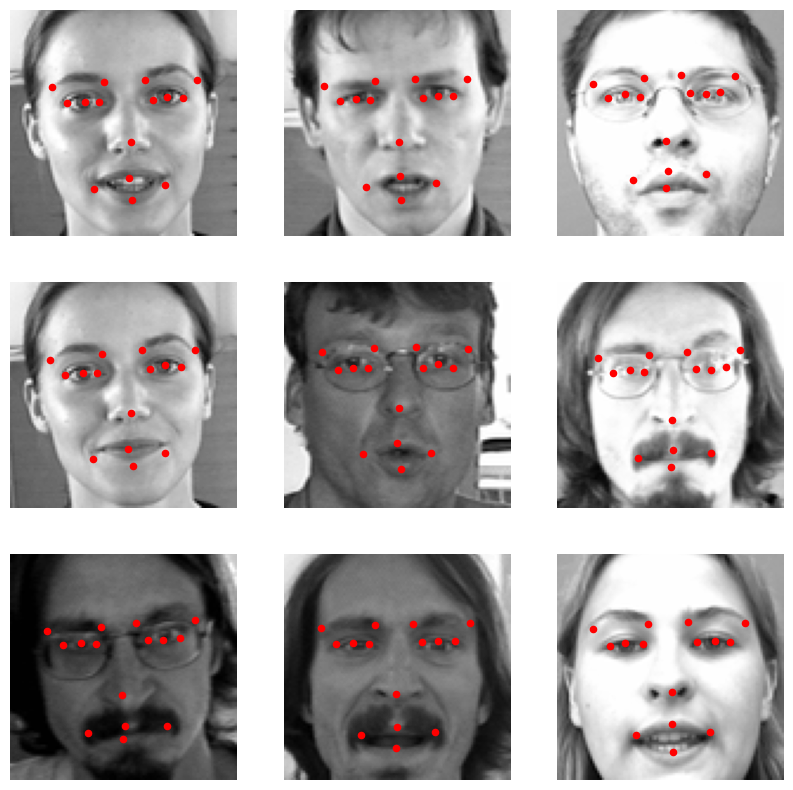

In [7]:
import matplotlib.pyplot as plt

def showPrediction(image, keypoints, size, idx): # Shows the image with the predicted keypoints
    plt.subplot(int(size ** 0.5), int(size ** 0.5), idx + 1)
    plt.imshow(image, cmap='gray')
    for i in range(0, len(keypoints), 2):
        plt.scatter(keypoints[i], keypoints[i+1], c='red', s=20)
    plt.axis('off')

X_test = X_test.reshape(-1, 96, 96)

plt.figure(figsize=(10, 10))
for idx in range(20, 29):
    showPrediction(X_test[idx], y_pred[idx], 9, idx - 20)
plt.show()

In [ ]:
ids = {
    "left_eye_center_x": 0,
    "left_eye_center_y": 1,
    "right_eye_center_x": 2,
    "right_eye_center_y": 3, 
    "left_eye_inner_corner_x": 4,
    "left_eye_inner_corner_y": 5,
    "left_eye_outer_corner_x": 6,
    "left_eye_outer_corner_y": 7,
    "right_eye_inner_corner_x": 8,
    "right_eye_inner_corner_y": 9,
    "right_eye_outer_corner_x": 10,
    "right_eye_outer_corner_y": 11,
    "left_eyebrow_inner_end_x": 12,
    "left_eyebrow_inner_end_y": 13,
    "left_eyebrow_outer_end_x": 14,
    "left_eyebrow_outer_end_y": 15,
    "right_eyebrow_inner_end_x": 16,
    "right_eyebrow_inner_end_y": 17,
    "right_eyebrow_outer_end_x": 18,
    "right_eyebrow_outer_end_y": 19,
    "nose_tip_x": 20,
    "nose_tip_y": 21,
    "mouth_left_corner_x": 22,
    "mouth_left_corner_y": 23,
    "mouth_right_corner_x": 24,
    "mouth_right_corner_y": 25,
    "mouth_center_top_lip_x": 26,
    "mouth_center_top_lip_y": 27,
    "mouth_center_bottom_lip_x": 28,
    "mouth_center_bottom_lip_y":29
}

idTable = pd.read_csv('IdLookupTable.csv')

submission_df = pd.DataFrame(columns=['RowId', 'Location'])

# idTable.iloc[i, 0] = row id
#                 1  = Image id
#                 2  = Feature name
#                 3  = Location

rows = []
for i in range(len(idTable)):
    rowId = idTable.iloc[i, 0]
    location = y_pred[idTable.iloc[i, 1] - 1][ids[idTable.iloc[i, 2]]]
    rows.append([int(rowId), location])

submission_df = pd.DataFrame(rows, columns=['RowId', 'Location'])
submission_df.to_csv('submission.csv', index=False)
